<a href="https://colab.research.google.com/github/PsorTheDoctor/learning-from-observation/blob/master/notebooks/vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ViT: Vision Transformer

In [ ]:
!pip install -q keras --upgrade
import os
os.environ["KERAS_BACKEND"] = "jax"  # "tensorflow", "jax", "torch"
import keras
from keras import layers
from keras import ops
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(path):
    x_train = np.load(path + 'train/images.npy')
    y_train = np.load(path + 'train/joints.npy')
    x_test = np.load(path + 'test/images.npy')
    y_test = np.load(path + 'test/joints.npy')
    return x_train, y_train, x_test, y_test

In [ ]:
path = 'drive/MyDrive/learning-from-observation/data/snake/'
num_classes = 2
input_shape = (224, 224, 3)

x_train, y_train, x_test, y_test = load_data(path)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (4000, 224, 224, 3) - y_train shape: (4000, 2)
x_test shape: (1000, 224, 224, 3) - y_test shape: (1000, 2)


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 10
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
data_augmentation = keras.Sequential([
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ], name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


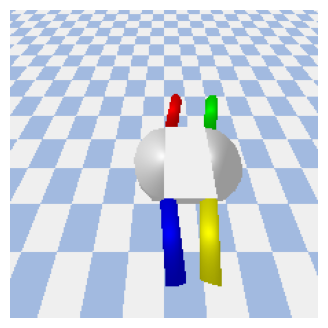

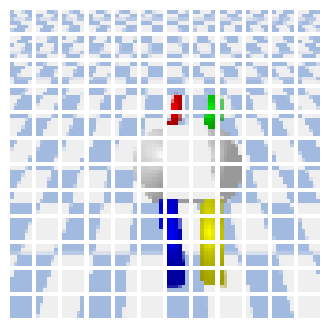

In [ ]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def __call__(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [ ]:
def build_vit():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

model = build_vit()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │          0 │ -                          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ data_augmentation         │ (None, 72, 72, 3)      │          7 │ input_layer[0][0]          │
│ (Sequential)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ patches_3 (Patches)       │ (None, 144, 108)       │          0 │ data_augmentation[0][0]    │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ dense (Dense)             │ (None, 144, 64)        │      6,976 │ patches_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ add (Add)                 │ (None, 144, 64)        │          0 │ dense[0][0]                │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ layer_normalization       │ (None, 144, 64)        │        128 │ add[0][0]                  │
│ (LayerNormalization)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ multi_head_attention      │ (None, 144, 64)        │     66,368 │ layer_normalization[0][0], │
│ (MultiHeadAttention)      │                        │            │ layer_normalization[0][0]  │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ add_1 (Add)               │ (None, 144, 64)        │          0 │ multi_head_attention[0][0… │
│                           │                        │            │ add[0][0]                  │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ layer_normalization_1     │ (None, 144, 64)        │        128 │ add_1[0][0]                │
│ (LayerNormalization)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ dense_1 (Dense)           │ (None, 144, 128)       │      8,320 │ layer_normalization_1[0][… │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 144, 128)       │          0 │ dense_1[0][0]              │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ dense_2 (Dense)           │ (None, 144, 64)        │      8,256 │ dropout_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 144, 64)        │          0 │ dense_2[0][0]              │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ add_2 (Add)               │ (None, 144, 64)        │          0 │ dropout_2[0][0],           │
│                           │                        │            │ add_1[0][0]                │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ layer_normalization_2     │ (None, 144, 64)        │        128 │ add_2[0][0]                │
│ (LayerNormalization)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ multi_head_attention_1    │ (None, 144, 64)        │     66,368 │ layer_normalization_2[0][… │
│ (MultiHeadAttention) 

 Total params: 21,651,403 (82.59 MB)

 Trainable params: 21,651,396 (82.59 MB)

 Non-trainable params: 7 (28.00 B)

##Snake

In [ ]:
def train():
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.Huber(),
        metrics=[
            keras.metrics.MeanSquaredError(),
            keras.metrics.MeanAbsoluteError()
        ]
    )
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_test, y_test)
    )
    return history

In [ ]:
history_snake = train()

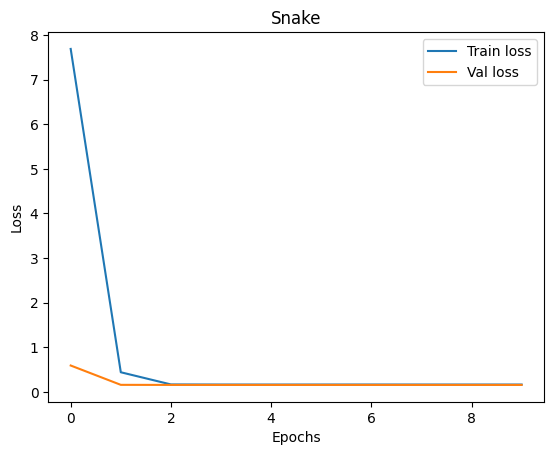

In [ ]:
plt.plot(history_snake.history['loss'], label='Train loss')
plt.plot(history_snake.history['val_loss'], label='Val loss')
plt.title('Snake')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
np.save('vit_snake_train.npy', y_pred_train)
np.save('vit_snake_test.npy', y_pred_test)

pred = pd.concat([
    pd.DataFrame(np.squeeze(y_pred_test), columns=['Pred joint 1', 'Pred joint 2']),
    pd.DataFrame(np.squeeze(y_test), columns=['True joint 1', 'True joint 2']),
    pd.DataFrame(np.squeeze(np.abs(y_test - y_pred_test)), columns=['Error joint 1', 'Error joint 2'])
], axis=1)
pred.head()

In [ ]:
mean_train = np.mean(np.abs(y_train - y_pred_train))
std_train = np.std(np.abs(y_train - y_pred_train))
mean_test = np.mean(np.abs(y_test - y_pred_test))
std_test = np.std(np.abs(y_test - y_pred_test))

print('Train mean:', mean_train)
print('Train std dev:', std_train)
print('Test mean:', mean_test)
print('Test std dev:', std_test)

Train mean: 0.500698
Train std dev: 0.28845695
Test mean: 0.48160645
Test std dev: 0.29266858


##Turtle

In [ ]:
path = 'drive/MyDrive/learning-from-observation/data/turtle/'
num_classes = 4
input_shape = (224, 224, 3)

x_train, y_train, x_test, y_test = load_data(path)

# Remove fixed joints
y_train = y_train[:, :4]
y_test = y_test[:, :4]

In [ ]:
history_turtle = train()

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 162s 4s/step - loss: 5.4214 - mean_absolute_error: 5.8216 - mean_squared_error: 216.9680 - val_loss: 0.0039 - val_mean_absolute_error: 0.0759 - val_mean_squared_error: 0.0077
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - loss: 0.0039 - mean_absolute_error: 0.0755 - mean_squared_error: 0.0078 - val_loss: 0.0038 - val_mean_absolute_error: 0.0756 - val_mean_squared_error: 0.0076
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - loss: 0.0038 - mean_absolute_error: 0.0751 - mean_squared_error: 0.0075 - val_loss: 0.0038 - val_mean_absolute_error: 0.0756 - val_mean_squared_error: 0.0076
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - loss: 0.0037 - mean_absolute_error: 0.0744 - mean_squared_error: 0.0074 - val_loss: 0.0038 - val_mean_absolute_error: 0.0755 - val_mean_squared_error: 0.0076
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - loss: 0.0037 - mean_absolute_error: 0.0748 - mean_squared_error: 0.0075 - val_loss: 0.0038 - val_mean

In [ ]:
plt.plot(history_turtle.history['loss'], label='Train loss')
plt.plot(history_turtle.history['val_loss'], label='Val loss')
plt.title('Turtle')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
np.save('cct_turtle_train.npy', y_pred_train)
np.save('cct_turtle_test.npy', y_pred_test)

pred = pd.concat([
    pd.DataFrame(np.squeeze(y_pred_test),
                 columns=['pred_joint_1', 'pred_joint_2', 'pred_joint_3', 'pred_joint_4']),
    pd.DataFrame(np.squeeze(y_test),
                 columns=['true_joint_1', 'true_joint_2', 'true_joint_3', 'true_joint_4']),
    pd.DataFrame(np.squeeze(np.abs(y_pred_test - y_test)),
                 columns=['error_joint_1', 'error_joint_2', 'error_joint_1', 'error_joint_2'])], axis=1)
pred.head()

In [ ]:
mean_train = np.mean(np.abs(y_train - y_pred_train))
std_train = np.std(np.abs(y_train - y_pred_train))
mean_test = np.mean(np.abs(y_test - y_pred_test))
std_test = np.std(np.abs(y_test - y_pred_test))

print('Train mean:', mean_train)
print('Train std dev:', std_train)
print('Test mean:', mean_test)
print('Test std dev:', std_test)

Train mean: 0.07466632
Train std dev: 0.043209303
Test mean: 0.07548843
Test std dev: 0.04320911
